In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

In [254]:
columns = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']
# Load the dataset
types = {'InvoiceNo': str, 'StockCode': str, 'Description': str, 'Quantity': int, 'InvoiceDate': str, 'UnitPrice': float, 'CustomerID': float, 'Country': str}
data = pd.read_csv('Online_Retail.csv', dtype=types, usecols=columns)

## Data preprocessing

In [255]:
prep_data = data[~data['InvoiceNo'].str.startswith('C')] # remove cancelled orders

In [256]:
prep_data.dropna(inplace=True) # remove rows with missing values

prep_data.drop_duplicates(inplace=True) # remove duplicate rows

In [257]:
prep_data['TotalPrice'] = prep_data['Quantity'] * prep_data['UnitPrice'] # calculate total price
prep_data['InvoiceDate'] = pd.to_datetime(prep_data['InvoiceDate']) # convert InvoiceDate to datetime




In [258]:
#remove outliers
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
prep_data = remove_outliers(prep_data, 'TotalPrice') # remove outliers in TotalPrice
prep_data = remove_outliers(prep_data, 'Quantity') # remove outliers in Quantity
prep_data = remove_outliers(prep_data, 'UnitPrice') # remove outliers in UnitPrice


#### RFM prepration

In [259]:
RFM = prep_data.groupby(
    ['CustomerID']
).agg(
    {
        'InvoiceDate': lambda x: (prep_data['InvoiceDate'].max() - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'
    }
)
RFM.columns = ['Recency', 'Frequency', 'Monetary']

In [260]:
for metric in ['Recency', 'Frequency', 'Monetary']:
    RFM = remove_outliers(RFM, metric)

#### Clustering

In [261]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

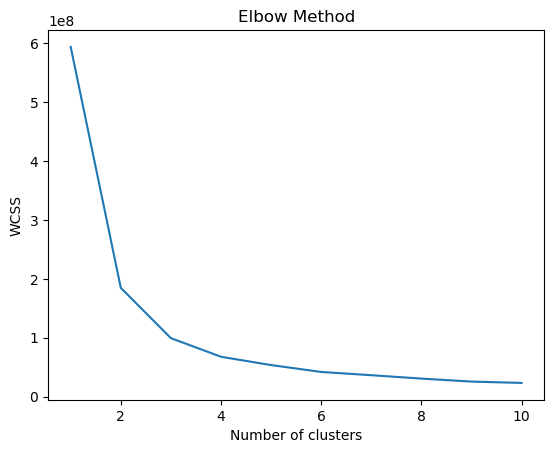

In [262]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(RFM[['Recency', 'Frequency', 'Monetary']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [263]:
# Test different numbers of clusters and calculate silhouette scores
from sklearn.metrics import silhouette_score

for n in range(2, 10):
    kmeans = KMeans(n_clusters=n, random_state=42)
    labels = kmeans.fit_predict(RFM[['Recency', 'Frequency', 'Monetary']])
    score = silhouette_score(RFM[['Recency', 'Frequency', 'Monetary']], labels)
    print(f"Number of Clusters: {n}, Silhouette Score: {score:.2f}")

Number of Clusters: 2, Silhouette Score: 0.63
Number of Clusters: 3, Silhouette Score: 0.53
Number of Clusters: 4, Silhouette Score: 0.47
Number of Clusters: 5, Silhouette Score: 0.40
Number of Clusters: 6, Silhouette Score: 0.41
Number of Clusters: 7, Silhouette Score: 0.42
Number of Clusters: 8, Silhouette Score: 0.39
Number of Clusters: 9, Silhouette Score: 0.40


In [264]:
kmeans = KMeans(n_clusters=2, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(RFM[['Recency', 'Frequency', 'Monetary']])

In [265]:
RFM['Cluster'].value_counts()

Cluster
0    2568
1     840
Name: count, dtype: int64

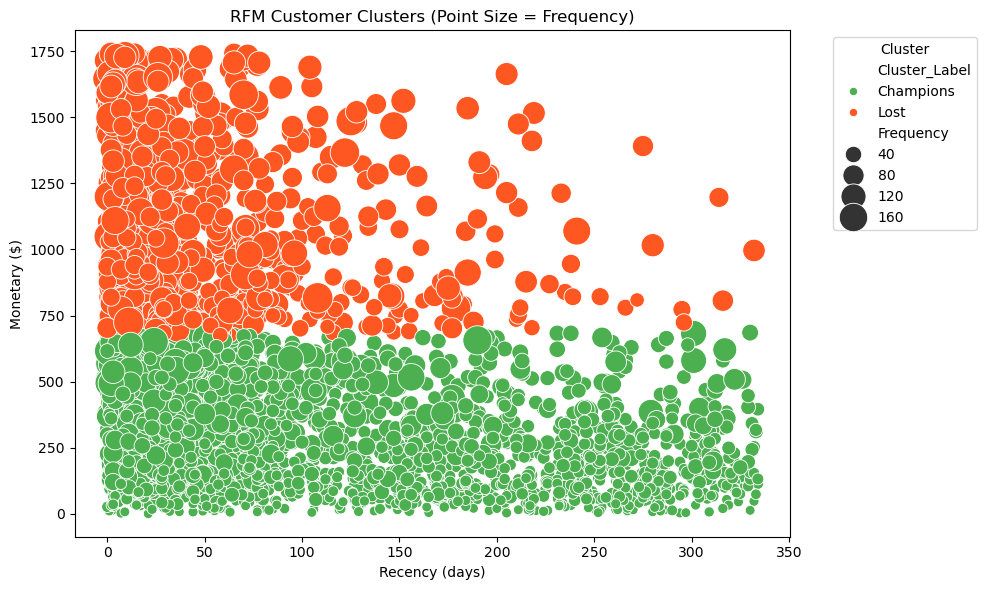

In [271]:
cluster_labels = {0: 'Champions', 1: 'Lost', 2: 'New Customers', 3: 'Churned'}
RFM['Cluster_Label'] = RFM['Cluster'].map(cluster_labels)

# Visualization 1: Scatter Plot (Recency vs. Monetary, Frequency as point size)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFM, x='Recency', y='Monetary', hue='Cluster_Label', 
                size='Frequency', sizes=(50, 500), palette=['#4CAF50', '#FF5722', '#2196F3', '#9E9E9E'])
plt.title('RFM Customer Clusters (Point Size = Frequency)')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

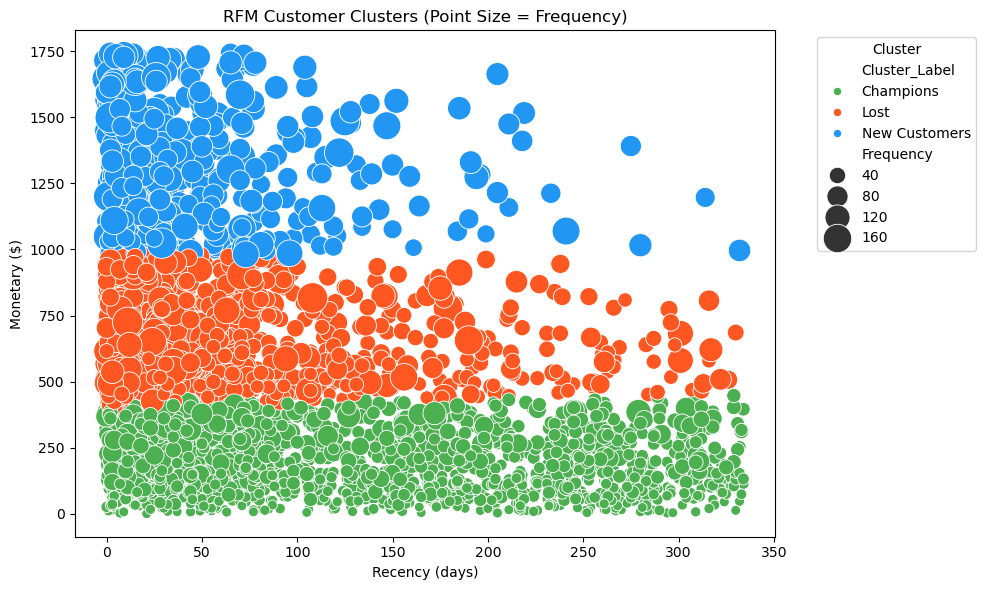

In [272]:
## try with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
RFM['Cluster'] = kmeans.fit_predict(RFM[['Recency', 'Frequency', 'Monetary']])
RFM['Cluster_Label'] = RFM['Cluster'].map({0: 'Champions', 1: 'Lost', 2: 'New Customers'})
plt.figure(figsize=(10, 6))
sns.scatterplot(data=RFM, x='Recency', y='Monetary', hue='Cluster_Label', 
                size='Frequency', sizes=(50, 500), palette=['#4CAF50', '#FF5722', '#2196F3'])
plt.title('RFM Customer Clusters (Point Size = Frequency)')
plt.xlabel('Recency (days)')
plt.ylabel('Monetary ($)')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()


DBSCAN model

Gasussion Mixture Model